In [7]:
import numpy as np
import torch
import cv2
import os
import matplotlib.pyplot as plt

from models.trba import TrBA
from utils import *
from data.utils import preprocess
from data.dataset import HWDataset
from data.utils import *

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
weight = './outputs/train_baseline_stn0_augment/best_cer.pth'
root_dir = '/mnt/disk1/nmduong/hust/intro2dl/data/words'

converter = AttnLabelConverter()

In [9]:
model = TrBA(
    img_channel=3,
    img_height=32,
    img_width=100,
    max_len=25,
    num_class = converter.num_classes,
    stn_on=False
).to(device)

In [10]:
model.load_state_dict(torch.load(weight)['model_state_dict'])
model.eval()
    
img_height = 32
img_width = 100
batch_size = 1
max_length = 25
        
def get_pred(fn):
    image = cv2.imread(fn).astype(np.float32)
    if image.ndim==2:
        image = image[np.newaxis]
    image = image.transpose((2,0,1))
    image = torch.from_numpy(image).type(torch.FloatTensor)
    image = preprocess(image, min_size=img_height, max_size=img_width)
    
    length_for_pred = torch.IntTensor([max_length] * batch_size).to(device)
    text_for_pred = torch.LongTensor(batch_size, max_length + 1).fill_(0).to(device)
    
    image = image.unsqueeze(0)
    model.eval()
    
    with torch.no_grad():
        preds, _ = model(image.to(device), text_for_pred, is_train=False)
    _, preds_index = preds.max(2)
    pred_str = converter.decode(preds_index, length_for_pred)[0]
    # print(pred_str)
    
    pred_EOS = pred_str.find('[s]')
    pred_str = pred_str[:pred_EOS]
    
    img2show = cv2.imread(fn)
    if img2show.ndim==2:
        img2show = img2show[np.newaxis]
    return pred_str, img2show


In [11]:
# test_dir = "./images"
# original_dir = '/mnt/disk1/nmduong/hust/intro2dl/data/new_train'
# n_samples = 20
# start_idx=100
# assert(n_samples%5==0)
# image_names = [f for f in os.listdir(original_dir)][start_idx:start_idx+n_samples]
# for n in image_names:
#     im = cv2.imread(os.path.join(original_dir, n))
#     cv2.imwrite(os.path.join(test_dir, n), im)

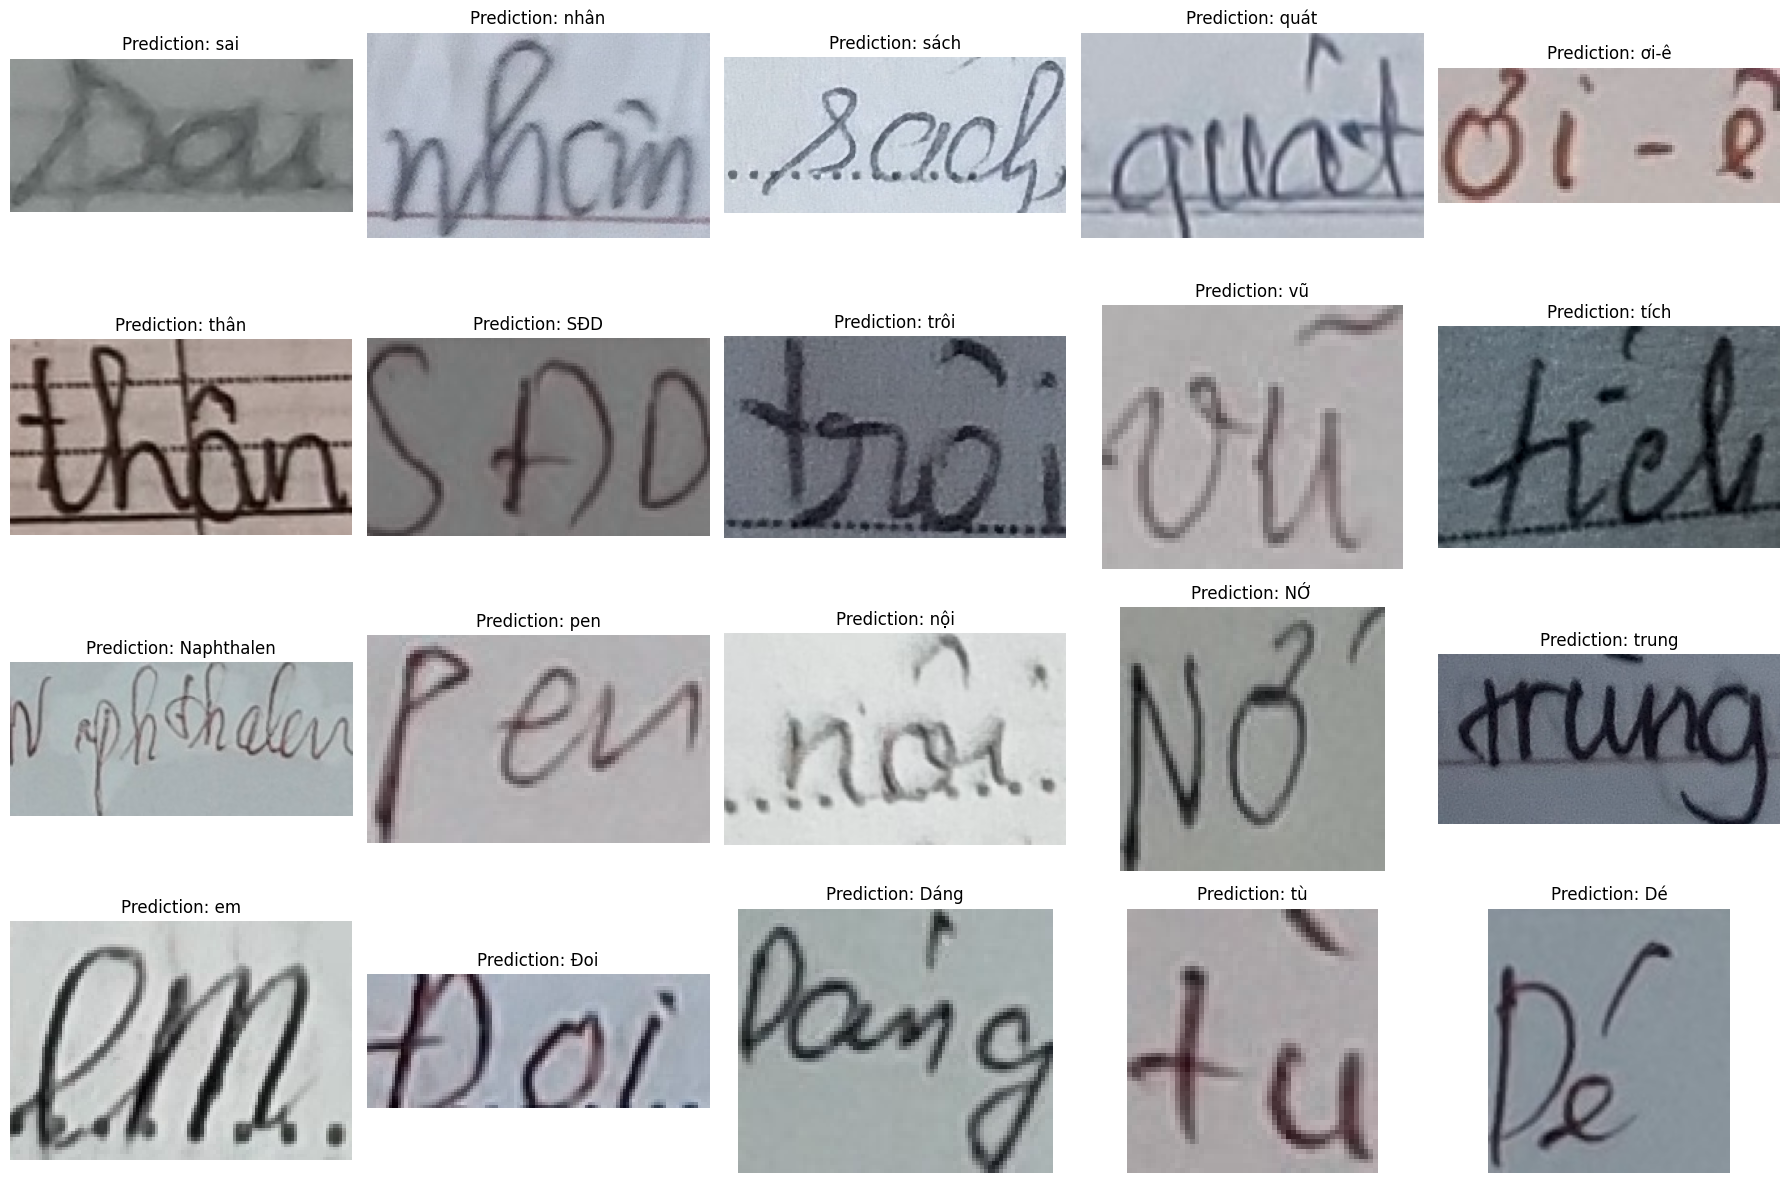

In [12]:
test_dir = "./images"
n_samples = 20
test_fn = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

ncols=5
nrows=n_samples//5

fig, ax = plt.subplots(nrows, ncols, figsize=(18, 12))

for i in range(nrows):
    for j in range(ncols):
        pred, img = get_pred(test_fn[i*ncols+j])
        
        ax[i][j].imshow(img)
        ax[i][j].set_title(f"Prediction: {pred}")
        ax[i][j].axis('off')
        plt.tight_layout()
        
plt.show()